In [1]:
##### Import packages #####
import sys
from KeckTools import *
%qtconsole

In [2]:
##### Simulation parameters #####
# Sizes
nPx = 4*70
D = 10.95
D_full = D*(70/45)
# wfs
nPx_wfs = 2*70
bin_wfs = int((nPx*2)/(nPx_wfs))
lambda_wfs = 1.65e-6                # H-band WFSing
lambda_D = lambda_wfs/D
k = 2*np.pi/lambda_wfs
wfs_tp = 0.1                        # Measured throughput
frameRate = 1000
dt = 1/frameRate
mod = 5                             # Modulation in lambda/D
modSteps = 24                       # Should be a factor of 4
# ngs
mag = 4
band = 'H'
wfs_thres = 0.5
# Science object (for now assume same number of photons)
lambda_sci = 2.2e-6
# Atmosphere
seeing = 0.5 #0.75" gives 0.13m r0 at 500nm. 
L0 = 80 # meter
windSpeed = 10                      # m/s
lambda_ref = 500e-9                 # Reference wavelength (i.e. for seeing)

convert=lambda_wfs #conversion factor to voltages. Currently converting to waves for numerical stability

/var/folders/nj/z5_057td3sz_kd52lnsptl200000gq/T/ipykernel_15765/1257127399.py:11: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  ap = circular_aperture(D)


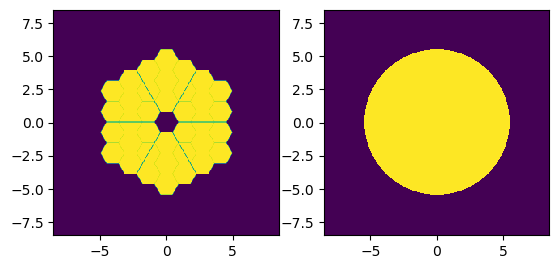

In [3]:
##### Setup grids and pupils #####
# High resolution pupil
pupil_grid = make_pupil_grid(nPx,D_full)
# wfs resolution
pwfs_grid = make_pupil_grid(nPx_wfs,D_full)
# Keck pupil
keck_aperture, segments = make_keck_aperture(return_segments=True,normalized=False)
pupil = evaluate_supersampled(keck_aperture, pupil_grid, 8)
segments = evaluate_supersampled(segments, pupil_grid, 8)
# Circular pupil
ap = circular_aperture(D)
circ_pupil = ap(pupil_grid)
# Plot pupil
plt.subplot(1,2,1)
imshow_field(pupil)
plt.subplot(1,2,2)
imshow_field(circ_pupil)

In [5]:
##### Setup the star & magnitude #####
nPhotons = flux(mag,band,wfs_tp,dt)

In [6]:
##### Setup the wavefront #####
# WF associated with the ngs
wf_ngs = Wavefront(pupil,wavelength=lambda_wfs)
wf_ngs.total_power = nPhotons
# WF associated with science
wf_sci = Wavefront(pupil,wavelength=lambda_sci)
wf_sci.total_power = nPhotons

In [7]:
##### Setup the focal plane propagator for wfs #####
focal_grid = make_focal_grid(q=8, num_airy=8,spatial_resolution=lambda_wfs)
propagator = FraunhoferPropagator(pupil_grid, focal_grid)

In [8]:
##### Setup the atmosphere #####
r0 = seeing_to_fried_parameter(seeing)
print(r0)
Cn_squared = Cn_squared_from_fried_parameter(r0,500e-9)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, L0, windSpeed)

0.20213951012215442


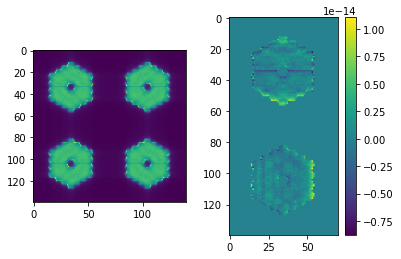

In [9]:
##### Setup the wfs #####
pwfs, mpwfs, wfs_camera = setupPyWFS(pupil_grid,mod,lambda_wfs,D,modSteps)

# Propagate a flat (reference) wavefront through the PyWFS
wf = Wavefront(pupil,lambda_wfs)

# Initiate the wfs
pwfs_im, pwfs_refSlopes, pwfs_mask, pupil_mask = initPyWFS(wfs_camera,mpwfs,wf,modSteps,bin_wfs,pwfs_grid,wfs_thres,dt)

# Plot the PyWFS image and reference slopes
[sx,sy] = slopeMaps(pwfs_refSlopes,pupil_mask)
plt.subplot(1,2,1)
plt.imshow(pwfs_im.reshape(pwfs_grid.shape))
plt.subplot(1,2,2)
plt.imshow(np.concatenate([sx,sy]))
plt.colorbar()

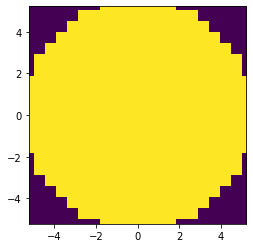

In [10]:
##### Setup the DM #####
#I am assuming that this is the same dm https://www.northropgrumman.com/wp-content/uploads/AOA-X-Deformable-Mirror-Technologies.pdf
# I get a 10% crosstalk from the paper
nAct = 21
crosstalk=0.1
dm, nModes, dm_pupil = setupZonalDM(nAct,D,pupil_grid,crosstalk)
imshow_field(dm_pupil)

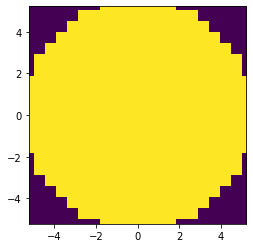

In [11]:
# Compute modal basis
calibBasis = 'zernike'
nModes = 350
modes = make_zernike_basis(nModes,D,pupil_grid,starting_mode=2)
mode_dm_proj = np.array(np.matmul(np.linalg.pinv(dm.influence_functions.transformation_matrix.todense()[circ_pupil==1,:][:,dm_pupil==1]),modes.transformation_matrix[circ_pupil==1,:]))
dm_modal = DeformableMirror(modes)##### Setup the DM #####
#I am assuming that this is the same dm https://www.northropgrumman.com/wp-content/uploads/AOA-X-Deformable-Mirror-Technologies.pdf
# I get a 10% crosstalk from the paper
nAct = 21
crosstalk=0.1
dm, nModes, dm_pupil = setupZonalDM(nAct,D,pupil_grid,crosstalk)

imshow_field(dm_pupil)

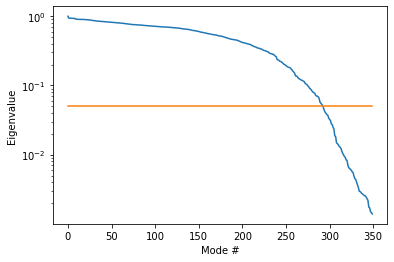

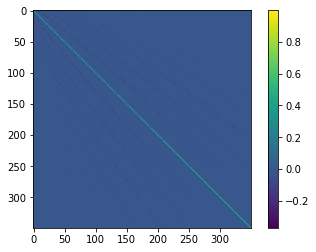

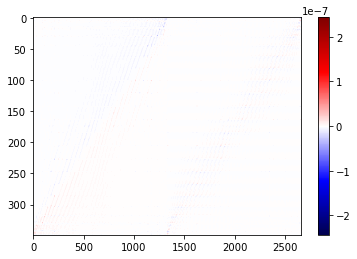

In [12]:
##### Calibrate the system #####
recalib = False
probe_amp = 0.02 * lambda_wfs
rcond = 0.05
if recalib:
    if calibBasis.lower()=='zonal':
        IM, CM, svd = calibratePyWFS(dm,dm_pupil,pupil,mpwfs,wfs_camera,lambda_wfs,modSteps,bin_wfs,pwfs_grid,pwfs_mask,pwfs_refSlopes,probe_amp,rcond,dt)
    else:
        validModes = np.ones(np.shape(dm_modal.actuators))
        IM, CM_modal, svd = calibratePyWFS(dm_modal,validModes,pupil,mpwfs,wfs_camera,lambda_wfs,modSteps,bin_wfs,pwfs_grid,pwfs_mask,pwfs_refSlopes,probe_amp,rcond,dt)
        np.save('IM_'+calibBasis.lower()+'.npy',IM)
        CM = np.matmul(mode_dm_proj,CM_modal)
else:
    if calibBasis.lower()=='zonal':
        IM = np.load('IM.npy')
        svd = SVD(IM)
        CM = computeCM(IM,rcond,svd)
    else:
        IM = np.load('IM_'+calibBasis.lower()+'.npy')
        svd = SVD(IM)
        CM_modal = computeCM(IM,rcond,svd)
        CM = np.matmul(mode_dm_proj,CM_modal)

# Plots
if calibBasis.lower()=='zonal':
    # Plot identity matrix
    plt.imshow(np.matmul(CM,IM))
    plt.colorbar()
    plt.show()
    # Look at the actuators which are controlled
    dm_ctrl = 0*dm_pupil.copy()
    dm_ctrl[dm_pupil==1] = np.diag(np.matmul(CM,IM))
    plt.imshow(dm_ctrl.reshape([nAct,nAct]))
    plt.show()
else:
    # Plot identity matrix
    plt.imshow(np.matmul(CM_modal,IM))
    plt.colorbar()
    plt.show()

cLim = np.max(np.abs(CM))
plt.imshow(CM,aspect='auto',cmap='seismic',vmin=-cLim,vmax=cLim)
plt.colorbar()
plt.show()

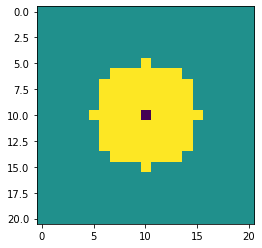

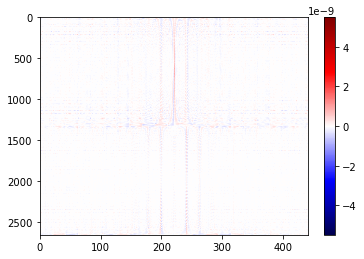

(2660, 441)


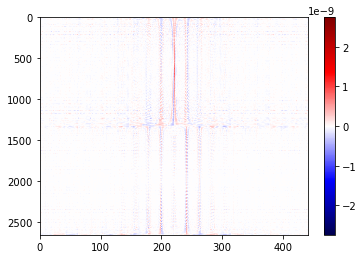

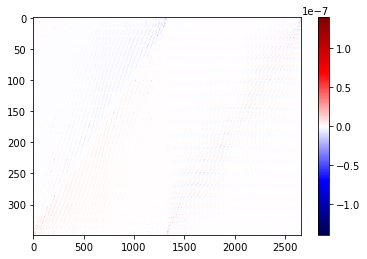

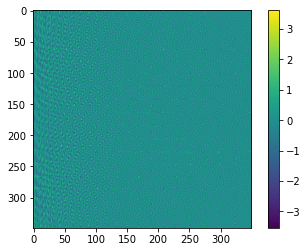

In [13]:
##### Fourier filtering #####
modalGains = [1,0.5]
cutOffFreq = mod
# Only want the valid actuators
CM_filt = applyModalGains(CM,cutOffFreq,nAct,dm_pupil.reshape([nAct,nAct]),modalGains)
plt.imshow(np.matmul(CM_filt,IM))
plt.colorbar()

In [14]:
# Add segemnted Keck mirror later
ksm =SegmentedDeformableMirror(segments)
ksm.flatten()
#ksm.random(120E-9)